<a href="https://colab.research.google.com/github/fudw/satellite-imagery-to-maps/blob/main/satellite-2-maps-cycleGAN-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite2Maps
### Automated creation of maps from satellite imagery and aerial sensor data with CycleGAN
<br/>

In this project, I develop a data pipeline that takes in satellite images and outputs maps using a CycleGAN model based on [*Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks*](https://arxiv.org/abs/1703.10593) by Zhu et al. (2017). 

The model will learn to convert satellite images to maps and vice versa, by training on public datasets in the two domains.

In [1]:
from google.colab import output

# download and unzip data
!gdown --id 1GSNhusWi-GXn4bOkymluer1Un7_YDBc9
!mkdir data
!unzip satellite-2-map-dataset-kaggle.zip -d data
output.clear()
print('Data downloaded!')

Data downloaded!


In [2]:
#!pip install wandb

# import libraries
import os
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import seaborn as sns
#import wandb

torch.manual_seed(9)

output.clear()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0+cu102 CPU


In [ ]:
wandb.login()

## II. Build CycleGAN Model

In [3]:
class ResidualBlock(nn.Module):
    '''
    ResidualBlock class.
    '''
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

In [4]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock class.
    '''
    def __init__(self, input_channels, use_in=True, kernel_size=3, activation='relu'):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU()
        if use_in:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_in = use_in

    def forward(self, x):
        x = self.conv1(x)
        if self.use_in:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [5]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock class.
    '''
    def __init__(self, input_channels, use_in=True):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, padding=1, stride=2, output_padding=1)
        if use_in:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_in = use_in
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_in:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

In [6]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock class.
    '''
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [7]:
class Generator(nn.Module):
    '''
    Generator class.
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super().__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.res9 = ResidualBlock(hidden_channels * res_mult)
        self.expand1 = ExpandingBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * res_mult // 2)
        self.downfeature = FeatureMapBlock(hidden_channels * res_mult // 4, output_channels)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.upfeature(x)
        x = self.contract1(x)
        x = self.contract2(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.res6(x)
        x = self.res7(x)
        x = self.res8(x)
        x = self.res9(x)
        x = self.expand1(x)
        x = self.expand2(x)
        x = self.downfeature(x)
        x = self.tanh(x)
        return x

In [8]:
class Discriminator(nn.Module):
    '''
    Discriminator class.
    '''
    def __init__(self, input_channels, hidden_channels=64):
        super().__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_in=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x = self.upfeature(x)
        x = self.contract1(x)
        x = self.contract2(x)
        x = self.contract3(x)
        x = self.final(x)
        return x

## III. Setup for Training

In [47]:
adv_criterion = nn.MSELoss()
recon_criterion = nn.L1Loss()

n_epochs = 2
dim_A = 3
dim_B = 3
display_step = 200
batch_size = 1
gen_lr = 0.0002
disc_lr = 0.001
load_shape = 300
target_shape = 256
device = 'cpu'

In [48]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((load_shape, load_shape * 2))
                                ])

dataset = torchvision.datasets.ImageFolder('data', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [20]:
def init_weights_random(model):
    if isinstance(model, nn.Conv2d) or isinstance(model, nn.ConvTranspose2d):
        nn.init.normal_(model.weight, 0., 0.2)
    #if isinstance(model, nn.InstanceNorm2d):
     #   nn.init.normal_(model.weight, 0., 0.2)
      #  nn.init.constant_(model.bias, 0)

def init_weights(gen_AB, gen_BA, disc_A, disc_B, checkpoint=None):
    if checkpoint is not None:
        loaded_state = torch.load(checkpoint)
        gen_AB.load_state_dict(loaded_state['gen_AB'])
        gen_BA.load_state_dict(loaded_state['gen_BA'])
        disc_A.load_state_dict(loaded_state['disc_A'])
        disc_B.load_state_dict(loaded_state['disc_B'])
    else:
        gen_AB.apply(init_weights_random)
        gen_BA.apply(init_weights_random)
        disc_A.apply(init_weights_random)
        disc_B.apply(init_weights_random)
    return gen_AB, gen_BA, disc_A, disc_B

In [18]:
gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=gen_lr, betas=(0.5, 0.999))
# gen_scheduler = torch.optim.lr_scheduler.OneCycleLR(gen_opt,
#                                                     max_lr=gen_lr,
#                                                     steps_per_epoch=len(dataloader),
#                                                     epochs=n_epochs,
#                                                     pct_start=0.1)
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(list(disc_A.parameters()), lr=disc_lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(list(disc_B.parameters()), lr=disc_lr, betas=(0.5, 0.999))
#disc_A_scheduler = torch.optim.lr_scheduler

In [21]:
gen_AB, gen_BA, disc_A, disc_B = init_weights(gen_AB, gen_BA, disc_A, disc_B)

In [22]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):
    real_Y = disc_X(real_X)
    real_loss = adv_criterion(real_Y, torch.ones_like(real_Y))
    fake_Y = disc_X(fake_X.detach())
    fake_loss = adv_criterion(fake_Y, torch.zeros_like(fake_Y))
    disc_loss = (real_loss + fake_loss) / 2
    return disc_loss

In [23]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X)
    pred = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(pred, torch.ones_like(pred))
    return adversarial_loss, fake_Y

In [24]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)
    return identity_loss, identity_X

In [25]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(real_X, cycle_X)
    return cycle_loss, cycle_X

In [41]:
def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=10):
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    identity_loss_AA, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_BB, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    cycle_loss_AA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_BB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    total_adv_loss = adv_loss_AB + adv_loss_BA
    total_identity_loss = identity_loss_AA + identity_loss_BB
    total_cycle_loss = cycle_loss_AA + cycle_loss_BB
    gen_loss = total_adv_loss + lambda_identity * total_identity_loss + lambda_cycle * total_cycle_loss
    return gen_loss, fake_A, fake_B

In [27]:
def plot_losses(losses):
    gen_loss = losses['gen']
    disc_A_loss = losses['disc_A']
    disc_B_loss = losses['disc_B']
    steps = losses['steps']

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    sns.lineplot(ax=axes[0], x=steps, y=gen_loss)
    axes[0].set_title('Generator loss')
    axes[0].set_xlabel('Steps')
    sns.lineplot(ax=axes[1], x=teps, y=disc_A_loss)
    axes[1].set_title('Discriminator A loss')
    axes[1].set_xlabel('Steps')
    sns.lineplot(ax=axes[2], x=steps, y=disc_B_loss)
    axes[2].set_title('Discriminator B loss')
    axes[2].set_xlabel('Steps')
    plt.show()

In [28]:
def show_image(image_tensor, num_images=3, size=(3, 256, 256)):
    image_copy = image_tensor
    image_unflat = image_copy.detach().cpu().view(-1, *size)
    image_unnormalized = (image_unflat + 1) / 2
    image_grid = make_grid(image_unnormalized[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

In [56]:
def create_grid(image_list, num_images=3, shape=(3, 256, 256)):
    processed_images = []
    for img in image_list:
        img_copy = img
        img_unflat = img_copy.detach().cpu().view(-1, *shape)
        img_unnormalized = (img_unflat + 1) / 2
        processed_images.append(img_unnormalized)
    image_grid = [make_grid([processed_images[i][j] for i in range(len(image_list))], nrow=5) for j in range(num_images)]
    grid = torch.cat(image_grid, dim=1)
    return grid.permute(1, 2, 0).squeeze()

In [54]:
def train(save_model=False):
    mean_gen_loss = 0
    mean_disc_A_loss = 0
    mean_disc_B_loss = 0
    current_step = 0
    losses = {'steps': [],
              'gen': [],
              'disc_A': [],
              'disc_B': []}

    for epoch in range(n_epochs):

        for img, _ in tqdm(dataloader):

            img_width = img.shape[3]
            img = img * 2 - 1
            real_A = img[:, :, :, :img_width // 2]
            real_B = img[:, :, :, img_width // 2:]
            real_A = transforms.RandomCrop(target_shape)(real_A)
            real_B = transforms.RandomCrop(target_shape)(real_B)
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            current_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            disc_A_opt.step()

            disc_B_opt.zero_grad()
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True)
            disc_B_opt.step()

            gen_opt.zero_grad()
            gen_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            gen_opt.step()

            mean_disc_A_loss += disc_A_loss.item() / display_step
            mean_disc_B_loss += disc_B_loss.item() / display_step
            mean_gen_loss += gen_loss.item() / display_step
            
            if current_step % display_step == 0:
                if current_step > 0:
                    print(f'Epoch {epoch} Step {current_step}: Generator loss {mean_gen_loss} Discriminator A loss {mean_disc_A_loss} Discriminator B loss {mean_disc_B_loss}')
                    losses['steps'].append(current_step)
                    losses['disc_A'].append(mean_disc_A_loss)
                    losses['disc_B'].append(mean_disc_B_loss)
                    losses['gen'].append(mean_gen_loss)
                    plot_losses(losses)
                else:
                    print('Initial state')
                
                preview = create_grid([real_A, fake_A, real_B, fake_B], num_images=1)
                plt.imshow(preview)
                plt.axis('off')
                plt.show()

                wandb.log({
                    'Steps': current_step,
                    'Generator loss': mean_gen_loss,
                    'Discriminator A loss': mean_disc_A_loss,
                    'Discriminator B loss': mean_disc_B_loss,
                    'Images': wandb.Image(preview),
                    'Generator LR': gen_opt.param_groups[0]['lr'],
                    # 'Discriminator A LR': disc_A_opt.param_groups[0]['lr'],
                    # 'Dsicriminator B LR': disc_B_opt.param_groups[0]['lr'],
                })

                mean_disc_A_loss = 0
                mean_disc_B_loss = 0
                mean_gen_loss = 0

            #disc_A_scheduler.step()
            #disc_B_scheduler.step()
            #gen_scheduler.step()
            current_step += 1
          
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            if save_model:
                torch.save({
                    'gen_AB': gen_AB.state_dict(),
                    'gen_BA': gen_BA.state_dict(),
                    'disc_A': disc_A.state_dict(),
                    'disc_B': disc_B.state_dict(),
                }, f'cycleGAN_ep{epoch}.pt')
        


In [ ]:
wandb.init(project='satellite2maps',
           confit={'epochs': n_epochs,
                   'batch_size': batch_size,
                   })
wandb.watch((gen, disc_A, disc_B), log_frequency=500)

  0%|          | 0/2194 [00:00<?, ?it/s]

Initial state


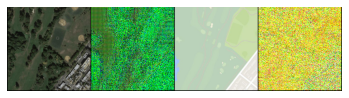

KeyboardInterrupt: ignored

In [57]:
start_time = time.time()
train()
elapsed = (time.time() - start_time) / 3600
print(f'--- {elapsed} hours elapsed ---')